# workflow

# 1. Extract & Label segments

# 2. Preprocess
   - Normalize
   - Label encode
   - get train/ val/ test

# 3. PyTorch Dataset + DataLoader
    - Custom class to serve (X,y)
    - Shuffle, batch, and argument

# 4. Build CNN Model
    - 1D CNN
    - Softmax classifier

# 5. Train Model
    - Loss: CrossEntropy
    - Optimizer: Adam
    - Metrics: accuracy, F1

# 6. Evaluate
    - Confusion matrix
    - Per-class performance
    - Visualize predictions

In [45]:
import os
os.environ["MKL_CBWR"] = "AVX"
os.environ["MKL_VERBOSE"] = "NO"
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import wfdb  # For reading .dat, .hea, .atr files
from wfdb import processing

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset


In [2]:
from collections import defaultdict
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import optuna
from optuna.trial import Trial
import math

In [3]:
DATA_DIR = "./data/physionet.org/files/mitdb/1.0.0"

In [4]:
record = wfdb.rdrecord(os.path.join(DATA_DIR, "100"))
annotation = wfdb.rdann(os.path.join(DATA_DIR, "100"), "atr")

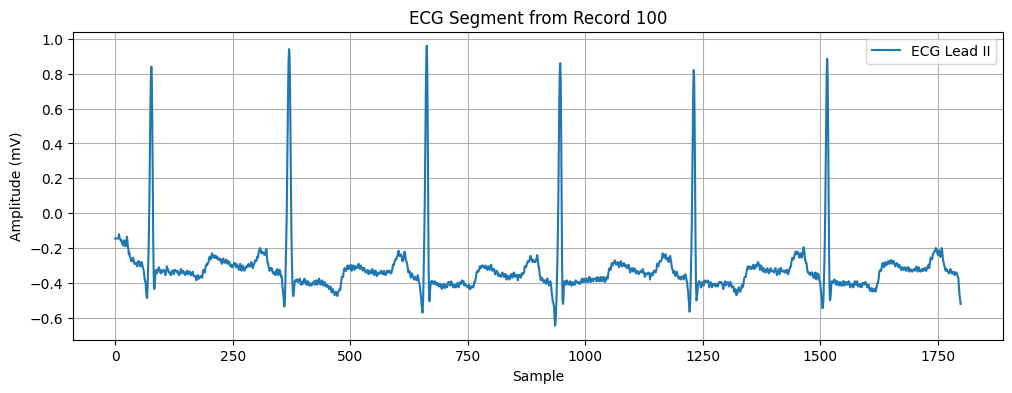

In [5]:
# Plot 5 seconds of signal
start = 0
end = int(record.fs * 5)  # 5 seconds worth of samples

plt.figure(figsize=(12, 4))
plt.plot(record.p_signal[start:end, 0], label="ECG Lead II")
plt.title("ECG Segment from Record 100")
plt.xlabel("Sample")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid(True)
plt.show()

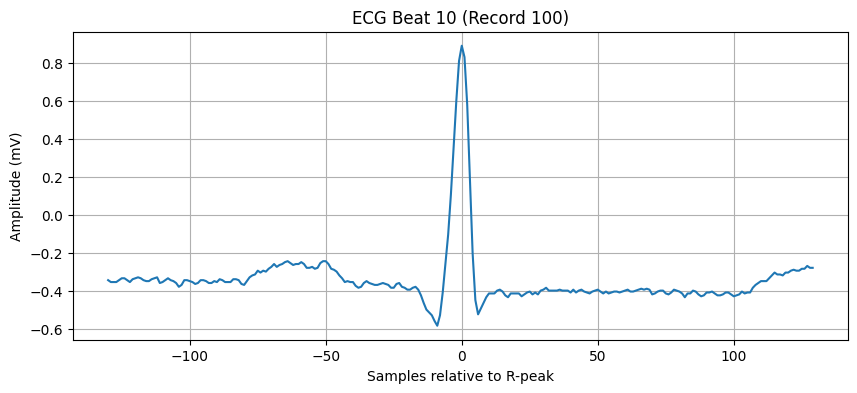

In [6]:
from wfdb import processing

# Load record and annotation
record = wfdb.rdrecord(os.path.join(DATA_DIR, "100"))
ann = wfdb.rdann(os.path.join(DATA_DIR, "100"), "atr")

# Extract signal and sample rate
signal = record.p_signal[:, 0]  
fs = record.fs  # 360 Hz

# Get R-peaks (sample indices)
r_peaks = annotation.sample

# Visualize one beat centered on the 10th R-peak
beat_index = 10
window_size = 130  # e.g., 130 samples before and after

center = r_peaks[beat_index]
start = center - window_size
end = center + window_size

if start < 0 or end >= len(signal):
    print("Beat too close to start or end of signal.")
else:
    beat = signal[start:end]

    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(-window_size, window_size), beat)
    plt.title(f"ECG Beat {beat_index} (Record 100)")
    plt.xlabel("Samples relative to R-peak")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True)
    plt.show()

### Step 1: Extract all beat segments and labels
- Use records from MIT-BIH 
- Loop through each beat
- Extract fixed-length segments
- Assign AAMI 5-class label
- Save as:
  -  `X`: (N, 256) numpy array of beat segments
  -  `y`: (N,) array of class labels

In [59]:
# load the records
RECORDS = [f"{i:03d}" for i in range(100, 235) if os.path.exists(os.path.join(DATA_DIR, f"{i:03d}.dat"))]

# set up the AAMI map as a dictionary 
AAMI_MAP = {
    'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    '/': 'Q', 'f': 'Q', 'Q': 'Q'
}

# define the class names and the label map
CLASS_NAMES = ['N', 'S', 'V', 'F', 'Q']
LABEL_MAP = {label: idx for idx, label in enumerate(CLASS_NAMES)}

# process all the data, extract the beats, and save into a npz file. 
X = []
y = []
count_by_class = defaultdict(int)

window_size = 130  # pre/post samples around R-peak

for rec in RECORDS:
    try:
        record = wfdb.rdrecord(os.path.join(DATA_DIR, rec))
        annotation = wfdb.rdann(os.path.join(DATA_DIR, rec), 'atr')

        signal = record.p_signal[:, 0]  # Lead II
        r_peaks = annotation.sample
        symbols = annotation.symbol

        for i, peak in enumerate(r_peaks):
            label = symbols[i]

            if label not in AAMI_MAP:
                continue

            cls = AAMI_MAP[label]
            label_idx = LABEL_MAP[cls]

            # Extract beat segment
            start = peak - window_size
            end = peak + window_size

            if start < 0 or end >= len(signal):
                continue

            segment = signal[start:end]
            X.append(segment)
            y.append(label_idx)
            count_by_class[cls] += 1

    except Exception as e:
        print(f"Error in record {rec}: {e}")

X = np.array(X)
y = np.array(y)

print(f" Total beats: {len(y)}")
print("Class distribution:")
for cls, count in count_by_class.items():
    print(f"  {cls}: {count}")

# Save
np.savez("./data/ecg_beat_dataset.npz", X=X, y=y, label_map=LABEL_MAP)
print(" Saved as ecg_beat_dataset.npz")

 Total beats: 109451
Class distribution:
  N: 90593
  S: 2781
  V: 7235
  Q: 8040
  F: 802
 Saved as ecg_beat_dataset.npz


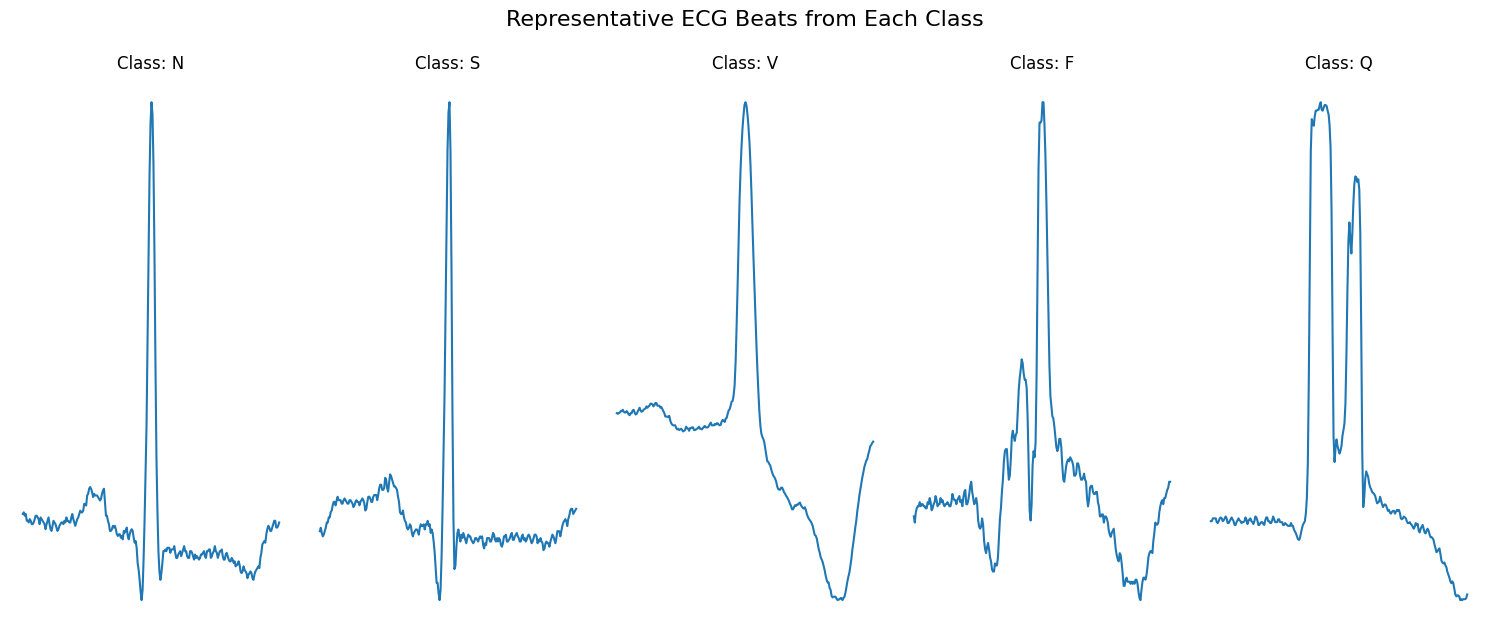

In [65]:
# Find one example for each class
example_beats = {}
for segment, label in zip(X, y):
    class_name = CLASS_NAMES[label]
    if class_name not in example_beats:
        example_beats[class_name] = segment
    if len(example_beats) == len(CLASS_NAMES):
        break

# Plot each example beat
plt.figure(figsize=(15, 6))
for idx, cls in enumerate(CLASS_NAMES):
    plt.subplot(1, len(CLASS_NAMES), idx + 1)
    segment = example_beats[cls]
    if cls in ['V', 'F', 'Q']:
        segment = -segment
    plt.plot(segment)
    plt.title(f"Class: {cls}")
    plt.axis('off')
    plt.tight_layout()

plt.suptitle("Representative ECG Beats from Each Class", fontsize=16, y=1.05)
plt.show()

### Step 2: preprocessing
- Denoising by one of the following smoothing functions. Plotting the original signal, the filtered signal, and using the residuals (i.e., original - filtered) to determine which filter is the best. 
    - Moving average: scipy.ndimage.uniform_filter1d()
    - Gaussian filter: scipy.ndimage.gaussian_filter1d()
    - Savitzky-Golay: scipy.signal.savgol_filter()
    - Median filter: scipy.signal.mdefilt()
- Normalization
    - per beat. We apply the Zscore method here (i.e., subtract the mean and divide the std)
- Split the full dataset into 70% train, 20% val, and 10% test
- Save the final processed dataset

In [9]:
data = np.load("./data/ecg_beat_dataset.npz")
for k in data.keys():
    print(k)
X = data['X']
y = data['y']

X
y
label_map


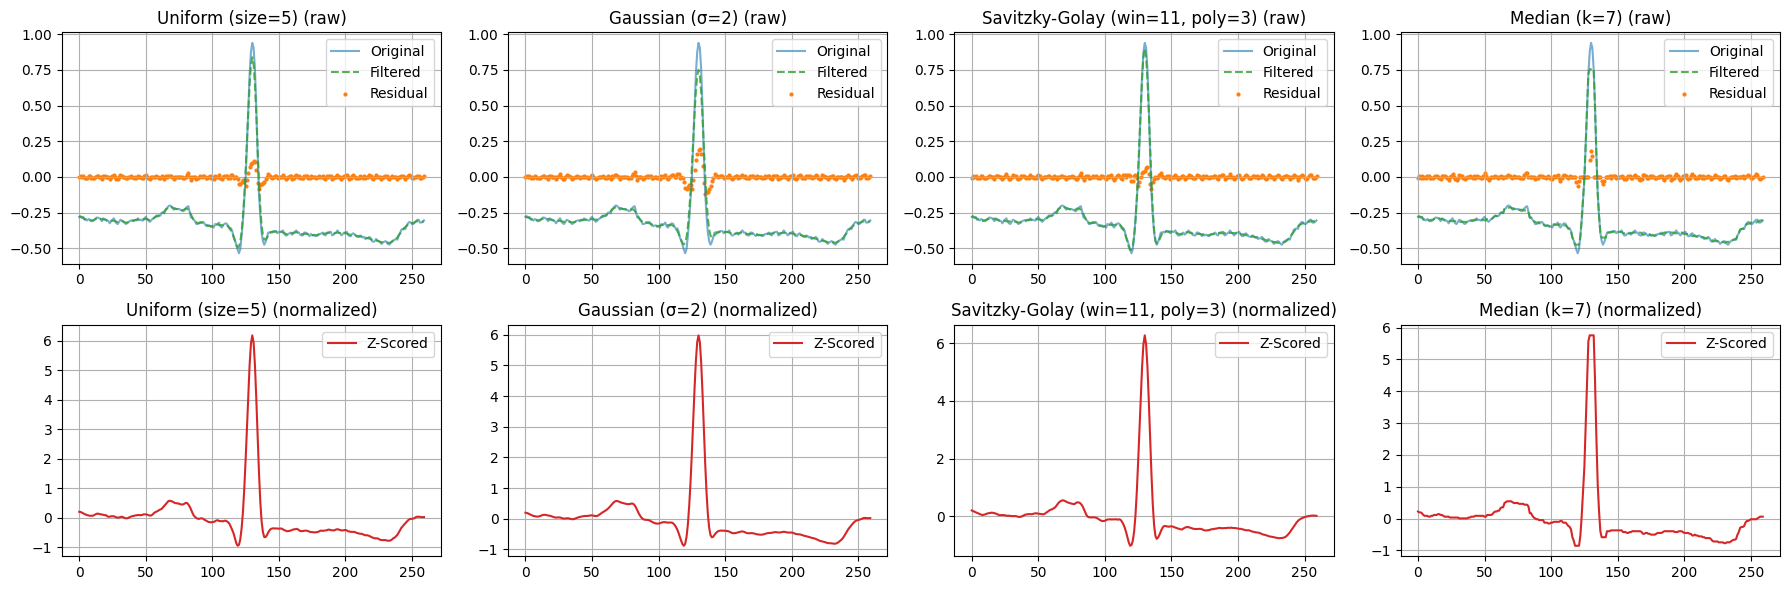

In [10]:
def zscore(x):
    return (x - np.mean(x)) / np.std(x)

# Choose a beat (e.g., X[0])
signal = X[0]

# Apply each filter
filters = {
    "Uniform (size=5)": scipy.ndimage.uniform_filter1d(signal, size=5),
    "Gaussian (σ=2)": scipy.ndimage.gaussian_filter1d(signal, sigma=2),
    "Savitzky-Golay (win=11, poly=3)": scipy.signal.savgol_filter(signal, window_length=11, polyorder=3),
    "Median (k=7)": scipy.signal.medfilt(signal, kernel_size=7),
}

# Plot: 2 rows × 4 filters (before and after normalization)
fig, axs = plt.subplots(2, 4, figsize=(18, 6))

for i, (name, filt) in enumerate(filters.items()):
    res = signal - filt
    norm = zscore(filt)
    
    # Row 0: before normalization
    axs[0, i].plot(signal, label="Original", color='tab:blue', alpha=0.6)
    axs[0, i].plot(filt, label="Filtered", linestyle='--', color='tab:green', alpha=0.8)
    axs[0,i].scatter(np.arange(len(res)), res, label="Residual", s=4, color='tab:orange')
    axs[0, i].set_title(f"{name} (raw)")
    axs[0, i].grid(True)

    # Row 1: after z-score normalization
    axs[1, i].plot(norm, label="Z-Scored", color='tab:red')
    axs[1, i].set_title(f"{name} (normalized)")
    axs[1, i].grid(True)

# Formatting
for ax in axs.ravel():
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## comment
- Since the residuals of the Savitzky-Golay is mostly flat, we decide to use it for denoising the signal.
- For normalization, we apply the Zscore to each beat. 

In [11]:
# Load dataset
data = np.load("./data/ecg_beat_dataset.npz")
X_raw = data['X']
y = data['y']

# Preprocessing functions
def preprocess_beat(beat):
    # Apply Savitzky-Golay filter
    smoothed = scipy.signal.savgol_filter(beat, window_length=11, polyorder=3)
    # Z-score normalization
    normed = (smoothed - np.mean(smoothed)) / np.std(smoothed)
    return normed

# Apply to all beats
X_processed = np.array([preprocess_beat(b) for b in X_raw])

# Split dataset: 70% train, 20% val, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X_processed, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

# Save to .npz files
np.savez("./data/ecg_train.npz", X=X_train, y=y_train)
np.savez("./data/ecg_val.npz", X=X_val, y=y_val)
np.savez("./data/ecg_test.npz", X=X_test, y=y_test)

print("Preprocessing complete. Datasets saved:")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")

Preprocessing complete. Datasets saved:
  Train: (76615, 260)
  Val:   (21890, 260)
  Test:  (10946, 260)


In [12]:
# define a PyTorch Dataset and DataLoader

class ECGDataset(Dataset):
    def __init__(self, file_path):
        data = np.load(file_path)
        self.X = torch.tensor(data['X'], dtype=torch.float32).unsqueeze(1)  # shape: (N, 1, 256)
        self.y = torch.tensor(data['y'], dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
train_ds = ECGDataset("./data/ecg_train.npz")
val_ds   = ECGDataset("./data/ecg_val.npz")
test_ds  = ECGDataset("./data/ecg_test.npz")

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

In [14]:
# the CNN model from the paper by Acharya et al.

class AcharyaCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(AcharyaCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=3, stride=1)  
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)                              

        self.conv2 = nn.Conv1d(in_channels=5, out_channels=10, kernel_size=4, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)                             

        self.conv3 = nn.Conv1d(in_channels=10, out_channels=20, kernel_size=4, stride=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)                              

        with torch.no_grad():
            dummy = torch.zeros(1, 1, 260)
            out = self.pool1(F.relu(self.conv1(dummy)))
            out = self.pool2(F.relu(self.conv2(out)))
            out = self.pool3(F.relu(self.conv3(out)))
            self.flatten_dim = out.view(1, -1).shape[1]
            # print("Calculated flatten_dim =", self.flatten_dim)
        
        # Flatten for fully connected layers
        self.fc1 = nn.Linear(self.flatten_dim, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, num_classes)

    def forward(self, x):
        assert x.shape[2] == 260, f"Expected input length 260, got {x.shape[2]}"
        x = self.pool1(F.relu(self.conv1(x)))   # (B, 5, 129)
        x = self.pool2(F.relu(self.conv2(x)))   # (B, 10, 63)
        x = self.pool3(F.relu(self.conv3(x)))   # (B, 20, 30)

        # print("Shape before flatten:", x.shape) 
        x = x.view(-1, self.flatten_dim)        # dynamic flattening
        x = F.relu(self.fc1(x))                 # (B, 30)
        x = F.relu(self.fc2(x))                 # (B, 20)
        x = self.fc3(x)                         # (B, 5)
        return x

In [51]:
# the baseline mode of 1DCNN
class ECGCNN(nn.Module):
    def __init__(self, kernel_size=5, dropout=0.3, filters1=32, filters2=64, fc1_size=130, num_classes=5, use_third_conv=False):
        super(ECGCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, filters1, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(filters1)
        self.conv2 = nn.Conv1d(filters1, filters2, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(filters2)
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(dropout)

        # Determine output size after conv+pool layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 260)
            out = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
            out = self.pool(F.relu(self.bn2(self.conv2(out))))
            self.flatten_dim = out.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flatten_dim, fc1_size)
        self.fc2 = nn.Linear(fc1_size, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # (B, 32, 130)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # (B, 64, 64)
        x = x.view(x.size(0), -1)                       # flatten
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_len=260, num_classes=5):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.lstm3 = nn.LSTM(input_size=32, hidden_size=16, batch_first=True)
        self.fc = nn.Linear(16 ,5)

    def forward(self, x):

        x = x.permute(0, 2, 1) # [batch_size, input_len, 1]
        
        out, (hn1, cn1) = self.lstm1(x)
        #print("After lstm1:")
        #print(f"  out shape: {out.shape}")
        #print(f"  hn1 shape: {hn1.shape}")
        
        out = self.dropout1(out)
        
        out, (hn2, cn2) = self.lstm2(out)
        #print("After lstm2:")
        #print(f"  out shape: {out.shape}")
        #print(f"  hn2 shape: {hn2.shape}")
        
        out = self.dropout2(out)
        
        out, (hn3, cn3) = self.lstm3(out)
        #print("After lstm3:")
        #print(f"  out shape: {out.shape}")
        #print(f"  hn3 shape: {hn3.shape}")
        
        out = hn3[-1,:,:]
        #print(f"Final squeezed hn shape: {out.shape}")
        
        out = self.fc(out)
        return out 

In [21]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=260):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TestiTransformer(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2,
                 dropout=0.1, max_len=260, num_classes=5):
        super(iTransformer, self).__init__()

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):

        x = x.transpose(1,2)
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)

        x = x.transpose(1,2)
        x = self.global_pool(x)
        x = x.squeeze(-1)
        
        return self.classifier(x)

In [30]:
class iTransformer(nn.Module):
    def __init__(self, input_len=260, num_classes=5, emb_dim=128, num_heads=4, ff_dim=256, num_layers=4, dropout=0.1):
        super(iTransformer, self).__init__()

        # Input projection (1D to emb_dim)
        self.input_proj = nn.Linear(input_len, emb_dim)

        # Positional Encoding
        self.pos_embed = nn.Parameter(torch.randn(1, emb_dim))
        #self.pos_embed = nn.Parameter(torch.randn(1, 261, emb_dim))
        
        # Transformer Encoder blocks
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, 
            nhead=num_heads, 
            dim_feedforward=ff_dim, 
            dropout=dropout, 
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))  # Instance token
        self.fc = nn.Sequential(
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, num_classes)
        )

    def forward(self, x):
        # x: (B, 1, 260)
        #x = x.transpose(0,2,1)
        B = x.size(0)

        # Flatten time into feature vector per instance: (B, emb_dim)
        x = self.input_proj(x.squeeze(1))  # (B, emb_dim)

        # Add a class token: (B, 1, emb_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, emb_dim]
        x = torch.cat((cls_tokens, x.unsqueeze(1)), dim=1)  # [B, 2, emb_dim]

        # Add positional encoding (simple fixed vector here)
        x = x + self.pos_embed

        # Pass through transformer
        x = self.transformer_encoder(x)  # (B, 2, emb_dim)

        # Take the CLS token output
        cls_out = x[:, 0, :]  # (B, emb_dim)
        return self.fc(cls_out)  # (B, num_classes)

### Architecture Comparison: AcharyaCNN vs. ECGCNN

| Layer        | AcharyaCNN                                | ECGCNN                                     |
|--------------|--------------------------------------------|--------------------------------------------|
| Input        | (B, 1, 260)                                | (B, 1, 260)                                 |
| Conv1        | Conv1D(1 → 5, kernel=3, stride=1)          | Conv1D(1 → 32, kernel=5, padding=2)         |
| Pool1        | MaxPool1D(kernel=2, stride=2)              | MaxPool1D(kernel=2)                         |
| Conv2        | Conv1D(5 → 10, kernel=4, stride=1)         | Conv1D(32 → 64, kernel=5, padding=2)        |
| Pool2        | MaxPool1D(kernel=2, stride=2)              | MaxPool1D(kernel=2)                         |
| Conv3        | Conv1D(10 → 20, kernel=4, stride=1)        | –                                           |
| Pool3        | MaxPool1D(kernel=2, stride=2)              | –                                           |
| Flatten Size | 600                                        | ~4096 (calculated dynamically)              |
| FC1          | Linear(600 → 30)                           | Linear(flatten_dim → 130)                   |
| FC2          | Linear(30 → 20)                            | Linear(130 → 5)                             |
| FC3          | Linear(20 → 5)                             | –                                           |
| Dropout      | –                                          | Dropout(0.3)                                |
| BatchNorm    | –                                          | BatchNorm1D in Conv1 & Conv2                |

### Summary of the comparison
| Feature                | AcharyaCNN                                  | ECGCNN                                        |
|------------------------|---------------------------------------------|-----------------------------------------------|
| Conv Layers            | 3 convolution layers                        | 2 convolution layers                          |
| Kernel Sizes           | 3 → 4 → 4                                   | 5 (same for both conv layers, with padding=2) |
| Channels               | 1 → 5 → 10 → 20                             | 1 → 32 → 64                                   |
| Pooling                | After each conv layer (MaxPool1d, stride=2) | After each conv layer (MaxPool1d, stride=2)   |
| BatchNorm              | No                                          | Yes, after each conv layer                    |
| Dropout                | No                                          | 0.3 after FC1                                 |
| Fully Connected Layers | 3 layers: 600 → 30 → 20 → 5                 | 2 layers: flattened → 130 → 5                 |
| Note                   | Ref: Acharya et al.                         | with regularization (BatchNorm and Dropout)   |

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.



Training AcharyaCNN...
------------------------------
Epoch  1/20 | Train Loss: 0.3517 | Val Loss: 0.1916 | Val Acc: 0.9506
Epoch  2/20 | Train Loss: 0.1628 | Val Loss: 0.1428 | Val Acc: 0.9594
Epoch  3/20 | Train Loss: 0.1310 | Val Loss: 0.1313 | Val Acc: 0.9622
Epoch  4/20 | Train Loss: 0.1139 | Val Loss: 0.1050 | Val Acc: 0.9725
Epoch  5/20 | Train Loss: 0.1006 | Val Loss: 0.0977 | Val Acc: 0.9732
Epoch  6/20 | Train Loss: 0.0933 | Val Loss: 0.0912 | Val Acc: 0.9737
Epoch  7/20 | Train Loss: 0.0869 | Val Loss: 0.0853 | Val Acc: 0.9762
Epoch  8/20 | Train Loss: 0.0828 | Val Loss: 0.0833 | Val Acc: 0.9760
Epoch  9/20 | Train Loss: 0.0776 | Val Loss: 0.0831 | Val Acc: 0.9777
Epoch 10/20 | Train Loss: 0.0744 | Val Loss: 0.0843 | Val Acc: 0.9758
Epoch 11/20 | Train Loss: 0.0706 | Val Loss: 0.0749 | Val Acc: 0.9797
Epoch 12/20 | Train Loss: 0.0677 | Val Loss: 0.0760 | Val Acc: 0.9798
Epoch 13/20 | Train Loss: 0.0641 | Val Loss: 0.0680 | Val Acc: 0.9802
Epoch 14/20 | Train Loss: 0.0616 | 

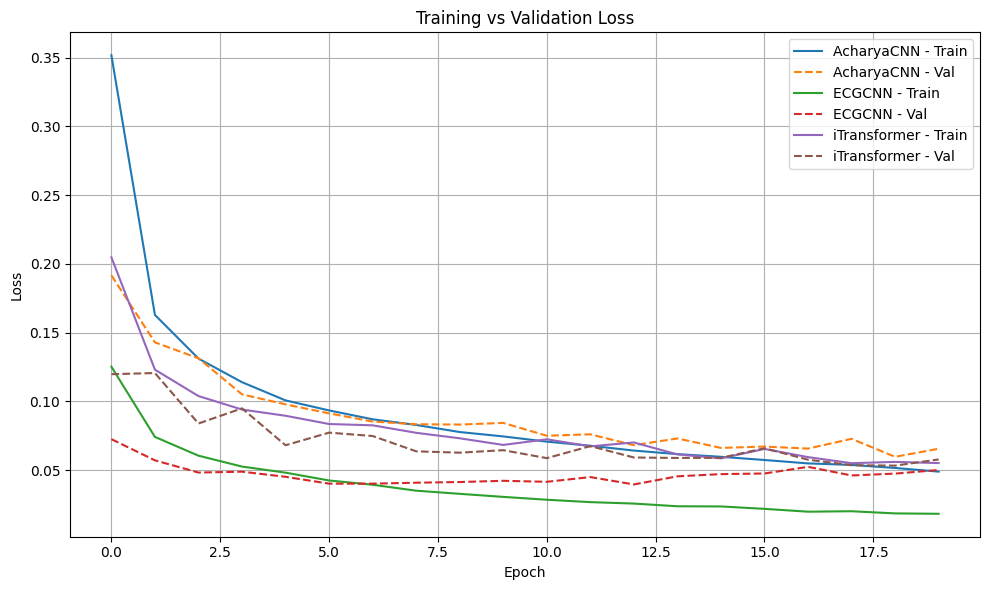

In [35]:
# Initialize models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = AcharyaCNN(num_classes=5).to(device)
model2 = ECGCNN(num_classes=5).to(device)
#model3 = LSTM(num_classes=5).to(device)
model3 = iTransformer(num_classes=5).to(device)

models = {'AcharyaCNN': model1, 'ECGCNN': model2, 'iTransformer': model3}
#models = {'iTransformer':model4}
histories = {}

EPOCHS = 20

for name, model in models.items():
    print(f"\nTraining {name}...\n" + "-"*30)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            #outputs = model(X_batch)

            #print(f"X_batch shape before model: {X_batch.shape}")
            try:
                outputs = model(X_batch)
            except Exception as e:
                print("Error during forward pass:", e)
            
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = correct / total

        print(f"Epoch {epoch+1:2}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save history
    histories[name] = {
        'train_loss': train_losses,
        'val_loss': val_losses
    }

# Plotting
plt.figure(figsize=(10, 6))
for name, hist in histories.items():
    plt.plot(hist['train_loss'], label=f"{name} - Train")
    plt.plot(hist['val_loss'], label=f"{name} - Val", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## evaluate on the test set

In [37]:
def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = torch.argmax(model(X_batch), dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

print("AcharyaCNN Test Acc:", evaluate(model1, test_loader))
print("ECGCNN Test Acc:", evaluate(model2, test_loader))
#print("LSTM Test Acc:", evaluate(model3, test_loader))
print("iTransform Test Acc:", evaluate(model3, test_loader))

AcharyaCNN Test Acc: 0.983921067056459
ECGCNN Test Acc: 0.9904988123515439
iTransform Test Acc: 0.9846519276448018


## check on the confusion model

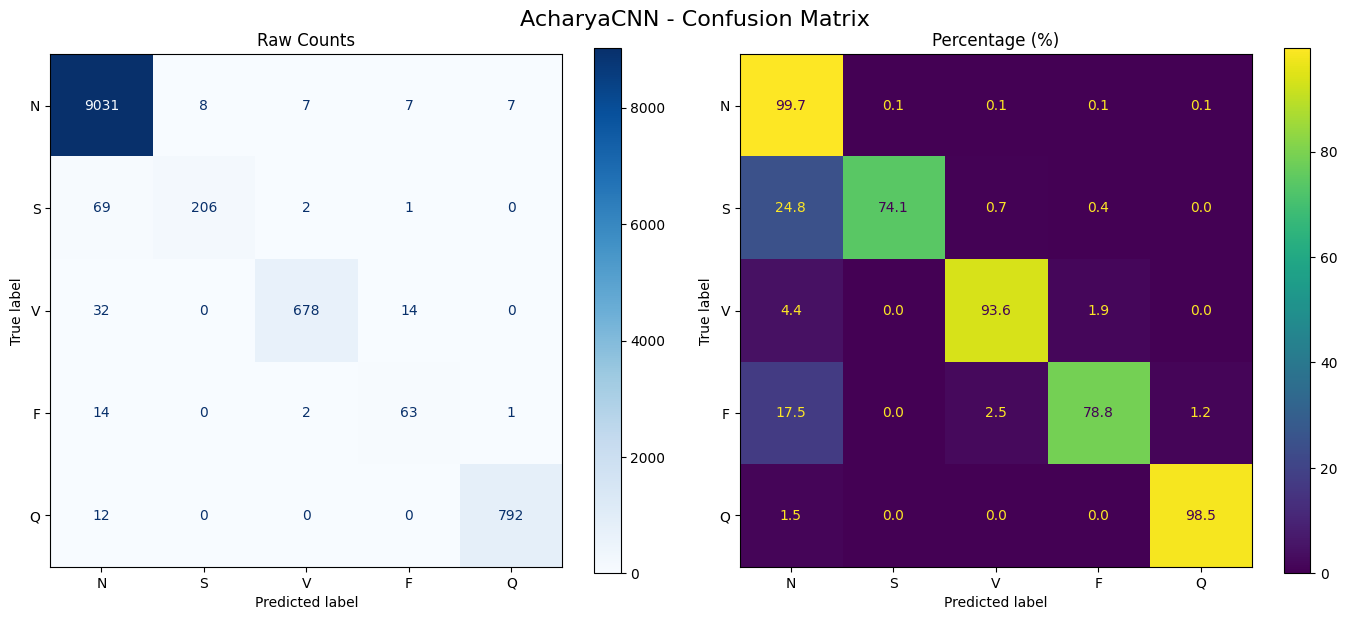

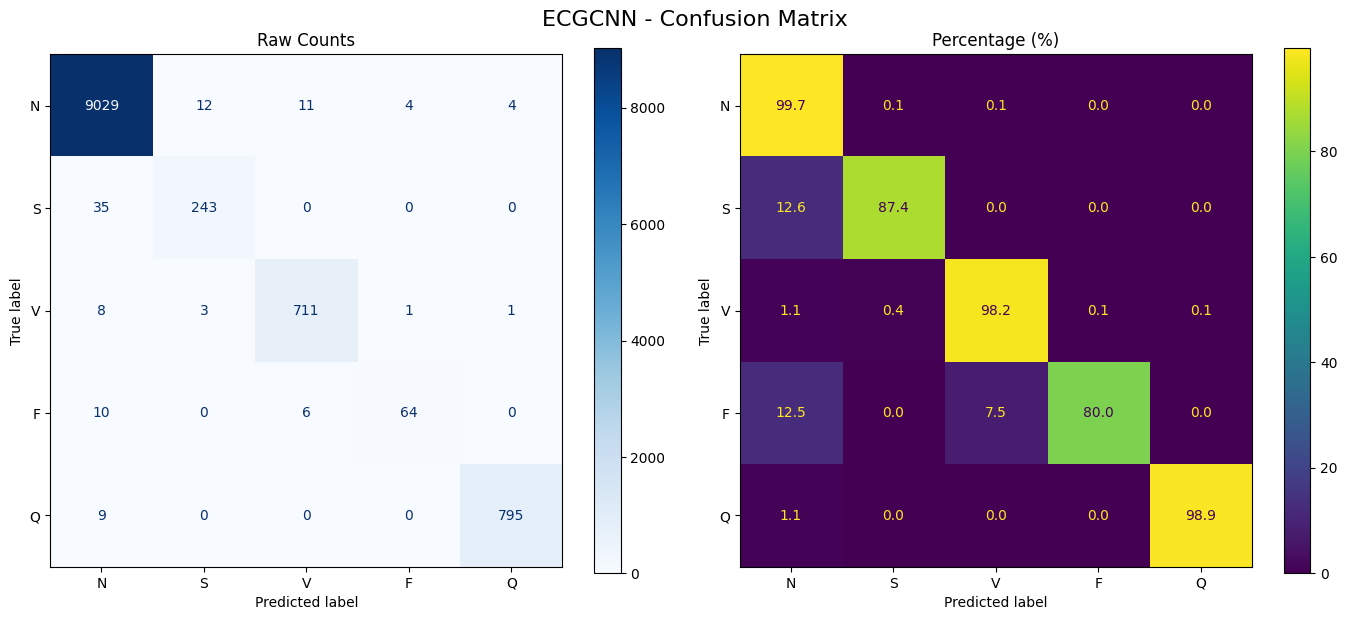

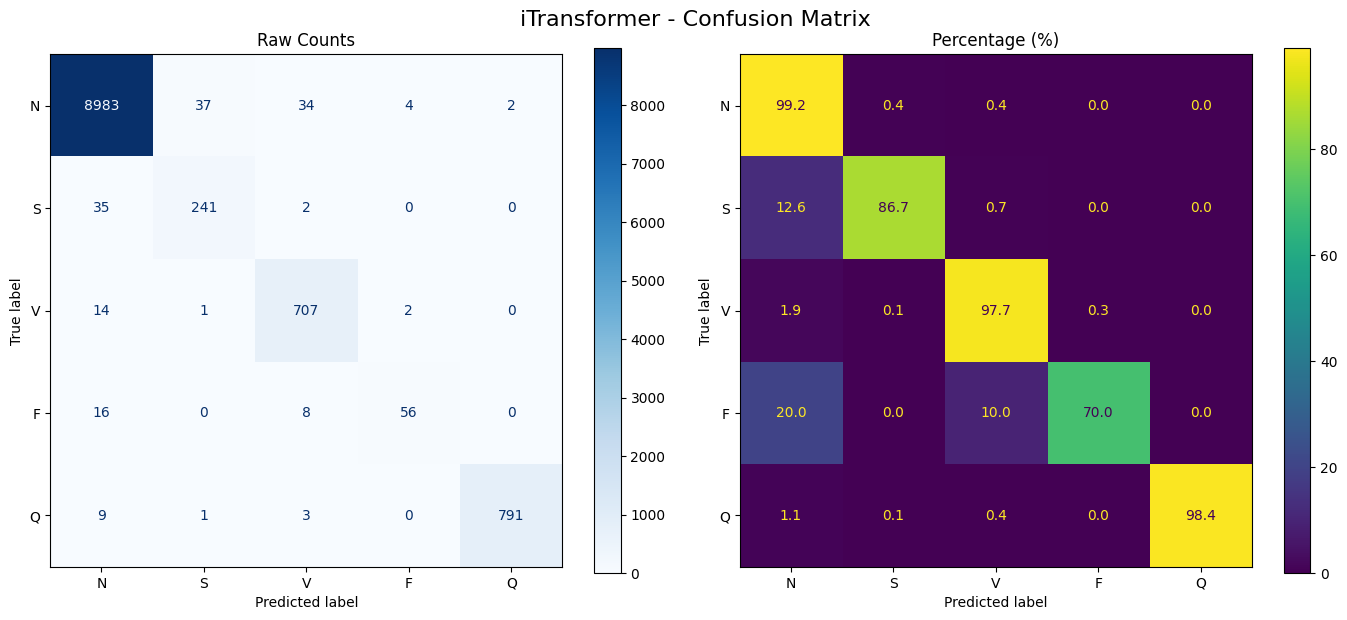

In [56]:
def plot_conf_matrix_dual(model, loader, class_names=None, title="Confusion Matrix"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            preds = torch.argmax(model(X_batch), dim=1).cpu().numpy()
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds)

    # Compute confusion matrices
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title, fontsize=16)

    # Left panel: Raw counts
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp1.plot(cmap="Blues", values_format="d", ax=axs[0], colorbar=True)
    axs[0].set_title("Raw Counts")

    # Right panel: Percentage
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=class_names)
    disp2.plot(cmap="viridis", values_format=".1f", ax=axs[1], colorbar=True)
    axs[1].set_title("Percentage (%)")

    plt.tight_layout()
    plt.show()

aami_labels = ["N", "S", "V", "F", "Q"]

plot_conf_matrix_dual(model1, test_loader, class_names=aami_labels, title="AcharyaCNN - Confusion Matrix")
plot_conf_matrix_dual(model2, test_loader, class_names=aami_labels, title="ECGCNN - Confusion Matrix")
plot_conf_matrix_dual(model3, test_loader, class_names=aami_labels, title="iTransformer - Confusion Matrix")

# Tuning the model

In [41]:
def objective(trial: Trial):
    # Hyperparameters to optimize
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5, 7])
    dropout_rate = trial.suggest_float('dropout', 0.0, 0.5)
    num_filters1 = trial.suggest_categorical('filters1', [16, 32, 64])
    num_filters2 = trial.suggest_categorical('filters2', [32, 64, 128])
    fc1_size = trial.suggest_categorical('fc1_size', [64, 130, 256])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    use_third_conv = trial.suggest_categorical('use_third_conv', [False, True])
    num_filters3 = trial.suggest_categorical('filters3', [64, 128, 256]) if use_third_conv else None

    class TunedECGCNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv1d(1, num_filters1, kernel_size=kernel_size, padding=kernel_size // 2)
            self.bn1 = nn.BatchNorm1d(num_filters1)
            self.conv2 = nn.Conv1d(num_filters1, num_filters2, kernel_size=kernel_size, padding=kernel_size // 2)
            self.bn2 = nn.BatchNorm1d(num_filters2)
            self.pool = nn.MaxPool1d(2)
            self.use_third_conv = use_third_conv

            if use_third_conv:
                self.conv3 = nn.Conv1d(num_filters2, num_filters3, kernel_size=kernel_size, padding=kernel_size // 2)
                self.bn3 = nn.BatchNorm1d(num_filters3)

            self.dropout = nn.Dropout(dropout_rate)

            with torch.no_grad():
                dummy = torch.zeros(1, 1, 260)
                x = self.pool(F.relu(self.bn1(self.conv1(dummy))))
                x = self.pool(F.relu(self.bn2(self.conv2(x))))
                if use_third_conv:
                    x = self.pool(F.relu(self.bn3(self.conv3(x))))
                self.flatten_dim = x.view(1, -1).shape[1]

            self.fc1 = nn.Linear(self.flatten_dim, fc1_size)
            self.fc2 = nn.Linear(fc1_size, 5)

        def forward(self, x):
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            if self.use_third_conv:
                x = self.pool(F.relu(self.bn3(self.conv3(x))))
            x = x.view(x.size(0), -1)
            x = self.dropout(F.relu(self.fc1(x)))
            return self.fc2(x)

    model = TunedECGCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Adjust training effort
    trial_number = trial.number
    short_mode = trial_number < 5
    num_epochs = 10 if short_mode else 25
    max_batches = 50 if short_mode else None

    best_acc = 0
    patience = 3
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        for i, (xb, yb) in enumerate(train_loader):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            if max_batches and i >= max_batches:
                break

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        val_accuracy = correct / total

        # Early stopping
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break

        trial.report(val_accuracy, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return 1.0 - best_acc

In [42]:
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3)
)
study.optimize(objective, n_trials=30)

[I 2025-07-22 17:15:29,744] A new study created in memory with name: no-name-95ff3ce5-d274-42a3-bf29-46faf4827de9
[I 2025-07-22 17:16:22,219] Trial 0 finished with value: 0.02476016445865692 and parameters: {'kernel_size': 5, 'dropout': 0.31363526744796183, 'filters1': 16, 'filters2': 32, 'fc1_size': 256, 'lr': 0.002601724548675938, 'weight_decay': 3.097076467743727e-06, 'use_third_conv': False}. Best is trial 0 with value: 0.02476016445865692.
[I 2025-07-22 17:17:31,857] Trial 1 finished with value: 0.04010963910461396 and parameters: {'kernel_size': 3, 'dropout': 0.20963011301689116, 'filters1': 32, 'filters2': 64, 'fc1_size': 64, 'lr': 0.00010774418807379734, 'weight_decay': 3.625657726574206e-05, 'use_third_conv': False}. Best is trial 0 with value: 0.02476016445865692.
[I 2025-07-22 17:20:33,856] Trial 2 finished with value: 0.03576975788031067 and parameters: {'kernel_size': 5, 'dropout': 0.23473624586754377, 'filters1': 32, 'filters2': 128, 'fc1_size': 130, 'lr': 0.0077065663126

In [43]:
# view the best results
print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {1.0 - trial.value:.4f}")
print("  Params:")
for k, v in trial.params.items():
    print(f"    {k}: {v}")

Best trial:
  Accuracy: 0.9752
  Params:
    kernel_size: 5
    dropout: 0.31363526744796183
    filters1: 16
    filters2: 32
    fc1_size: 256
    lr: 0.002601724548675938
    weight_decay: 3.097076467743727e-06
    use_third_conv: False


In [53]:
# === Step 1: Load your saved best params from Optuna ===
best_params = {
    'kernel_size': 5,
    'dropout': 0.3136,
    'filters1': 16,
    'filters2': 32,
    'fc1_size': 256,
    'lr': 0.0026,
    'weight_decay': 3.097e-6,
    'use_third_conv': False
}

# === Step 2: Prepare data (combine train + val) ===
# Replace X_train, X_val, etc. with your actual variables
X_trainval = np.concatenate([X_train, X_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

X_trainval = X_trainval[:, np.newaxis, :]  # Now shape is (N, 1, 260)
X_test = X_test[:, np.newaxis, :] 

trainval_dataset = TensorDataset(torch.tensor(X_trainval, dtype=torch.float32), 
                                 torch.tensor(y_trainval, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                             torch.tensor(y_test, dtype=torch.long))

trainval_loader = DataLoader(trainval_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# === Step 3: Rebuild model ===
model_optuna = ECGCNN(
    kernel_size=best_params['kernel_size'],
    dropout=best_params['dropout'],
    filters1=best_params['filters1'],
    filters2=best_params['filters2'],
    fc1_size=best_params['fc1_size']
).to(device)

optimizer = torch.optim.Adam(
    model_optuna.parameters(),
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay']
)

criterion = torch.nn.CrossEntropyLoss()

# === Step 4: Train the model ===
def train_model(model, loader, optimizer, criterion, epochs=30):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

# Train on full training data
train_model(model_optuna, trainval_loader, optimizer, criterion, epochs=30)

# === Step 5: Evaluate on test set ===
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

test_acc = evaluate(model_optuna, test_loader)
print(f"\n Final Test Accuracy: {test_acc:.4f}")

Epoch 1/30 - Loss: 184.0842
Epoch 2/30 - Loss: 99.0925
Epoch 3/30 - Loss: 79.5184
Epoch 4/30 - Loss: 66.6953
Epoch 5/30 - Loss: 60.7784
Epoch 6/30 - Loss: 54.3466
Epoch 7/30 - Loss: 50.3120
Epoch 8/30 - Loss: 46.0980
Epoch 9/30 - Loss: 44.1154
Epoch 10/30 - Loss: 40.8932
Epoch 11/30 - Loss: 39.3819
Epoch 12/30 - Loss: 38.6633
Epoch 13/30 - Loss: 35.1917
Epoch 14/30 - Loss: 35.2493
Epoch 15/30 - Loss: 34.1224
Epoch 16/30 - Loss: 32.7291
Epoch 17/30 - Loss: 31.3748
Epoch 18/30 - Loss: 30.5097
Epoch 19/30 - Loss: 29.4811
Epoch 20/30 - Loss: 29.2945
Epoch 21/30 - Loss: 28.2502
Epoch 22/30 - Loss: 27.1318
Epoch 23/30 - Loss: 28.1680
Epoch 24/30 - Loss: 26.2143
Epoch 25/30 - Loss: 27.2208
Epoch 26/30 - Loss: 25.1379
Epoch 27/30 - Loss: 25.6343
Epoch 28/30 - Loss: 25.3105
Epoch 29/30 - Loss: 25.2957
Epoch 30/30 - Loss: 25.8465

 Final Test Accuracy: 0.9921


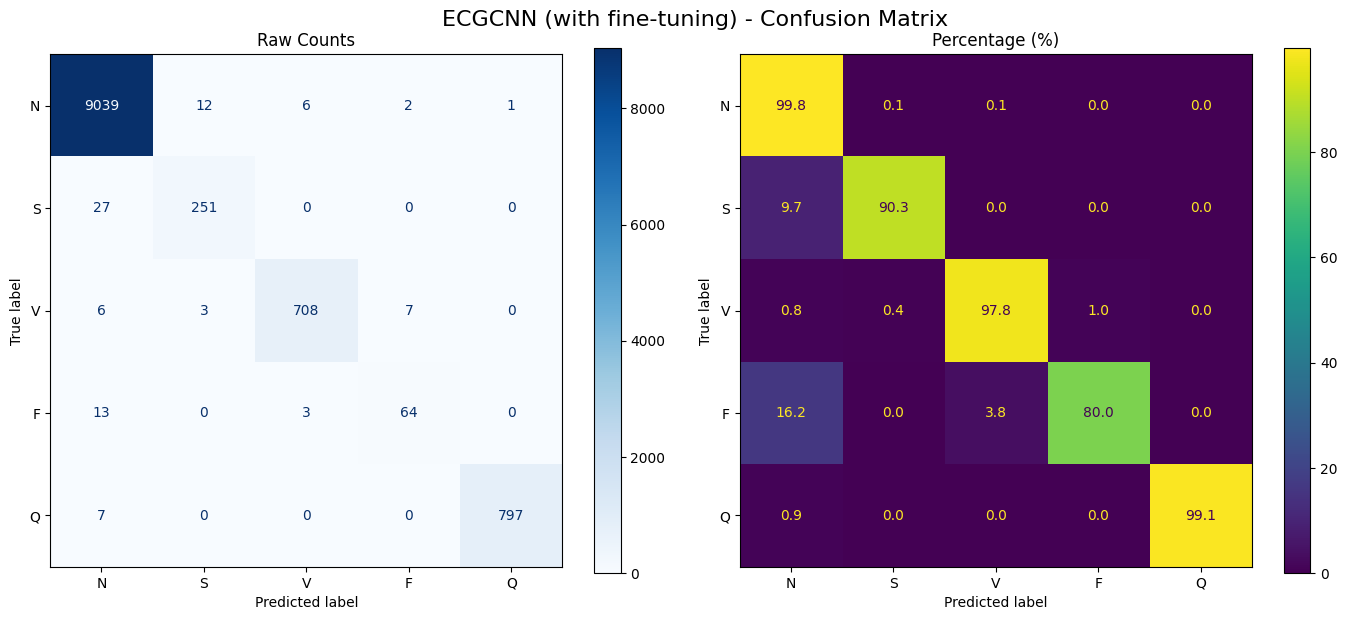

In [57]:
plot_conf_matrix_dual(model_optuna, test_loader, class_names=aami_labels, title="ECGCNN (with fine-tuning) - Confusion Matrix")